# Tutorial: Using NiftyNet to Train U-Net for Cell Segmentation 

In this tutorial, you'll learn how to use NiftyNet to implement the original 2D U-Net. This demo will take you through all the stages of a typical experiment, from data gathering through training, to analysing the results. 

## The problem: 

U-Net [1] is one of the (if not **_the_**) most popular neural net architecture in medical image computing. Its 2015 publication demonstrated a range of world-leading results on a variety of datasets. In this demonstration, we will show you how to use NiftyNet, an open-source platform for deep learning in medical image computing and computer assisted intervention, to train a U-Net and match these results. We also demonstrate how to test various configurations to compare different approaches (for example, which augmentation steps to use). 

## Before we start:

If you want to run the experiments yourself, you will need to download the appropriate libraries. In addition to NiftyNet, you will need: `scikit-image` and `simpleitk`. These are both available as python packages (you can `pip install` them. If you don't want to do that, feel free to read through this notebook! 

## What's here: 

1. [Setup](#setup)
2. [The data](#data)
3. [The architecture](#arch)
4. [The loss function](#loss)
5. [Visualising the Data](#vis)
6. [Data Augmentation](#aug)
7. [Configuration Files](#conf)
8. [Picking Augmentation Parameters: Visualisation](#datavis)
8. [The Experiments](#exp)
9. [Results](#results)
10. [Monitoring Training Progress](#tb)
11. [Analysing Results and Wrapping Up](#analysis)


<a id="setup"></a>
## The setup:
To replicate the paper's results, we have to look at: 

<a id="data"></a>

## The data: 
The U-Net paper operated on several different datasets from the "ISBI Cell Tracking Challenge 2015". To get access to these datasets, you can sign up [here](http://www.celltrackingchallenge.net/datasets.html). 

This paper shows results on the "PhC-U373" dataset, and the "DIC-HeLa" dataset. 

To run this demonstration as-is, download these datasets and unzip to `./data/u-net`. You should see the following folders at this location now: 

```
DIC-C2DH-HeLa  
PhC-C2DH-U373
```

Then run the following command: 

```python -m demos.unet.file_sorter```

to arrange the files in a more convenient way for us. 


<a id="arch"></a>
## The architecture: 

In terms of implementing the specific u-net architecture, we're in luck! NiftyNet has the 2-d unet implemented already. It's located at `niftynet.networks.unet_2d`, which you can find by searching the term `"unet"` at the [documentation page](http://niftynet.readthedocs.io/en/dev/) of NiftyNet.

<a id="loss"></a>
## The loss function: 

U-Net uses a weighted cross-entropy as its loss function. The per-pixel weights are given by a formula which: 

1. balances the weights between classes and 
2. has an extra term to penalise joining two bits of the segmentation. 


$$w(x) = w_c(x) + w_0 . exp \left( -\frac{(d_1(x) + d_2(x))^2}{2\sigma^2} \right)$$

which is equation 2 in the original paper. NiftyNet supports weighted loss functions, but we are going to have to create the weights ourselves. To do that, we can write a python script to generate these weights: 

The file I used to make these weights is in `demos/unet/make_cell_weights.py`

We'll have a look at some of the data here: 


In [1]:
import os 
import nibabel as nib 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from skimage.io import imread
import re

%matplotlib inline
def plot_slides(images, figsize=(10,5)):
    f, axes = plt.subplots(2,3, figsize=figsize)
    for i, slice_id in enumerate(images):
        axes[i][0].imshow(images[slice_id]['img'], cmap='gray')
        axes[i][0].set_title('Image %s' % slice_id)
        axes[i][1].imshow(images[slice_id]['seg'], cmap='gray')
        axes[i][1].set_title('Segmentation %s' % slice_id)
        axes[i][2].imshow(images[slice_id]['weight'], cmap='jet', vmin=0, vmax=10)
        axes[i][2].set_title('Weight Map %s' % slice_id)

        for ax in axes[i]:
            ax.set_axis_off()
    f.tight_layout()

    
def grab_demo_images(image_dir, slice_ids, image_prefix_dict):
    images = {slice_id: {
            key: imread(os.path.join(image_dir, image_prefix_dict[key] + '%s.tif' % slice_id))
            for key in image_prefix_dict} 
        for slice_id in slice_ids}
    return images
    

/home/zeatonro/anaconda3/envs/rage/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<a id="vis"></a>

## Visualising the data

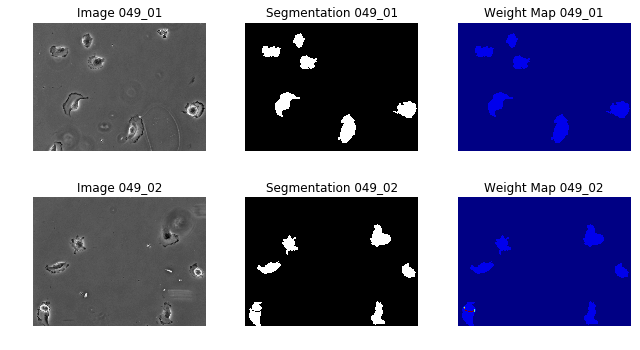

In [2]:
U373_dir = "../../data/u-net/PhC-C2DH-U373/niftynet_data"
U373_imgs = grab_demo_images(U373_dir, ['049_01', '049_02'], {'img': 'img_', 'seg': 'bin_seg_', 'weight': 'weight_'})

plot_slides(U373_imgs, figsize=(9,5))

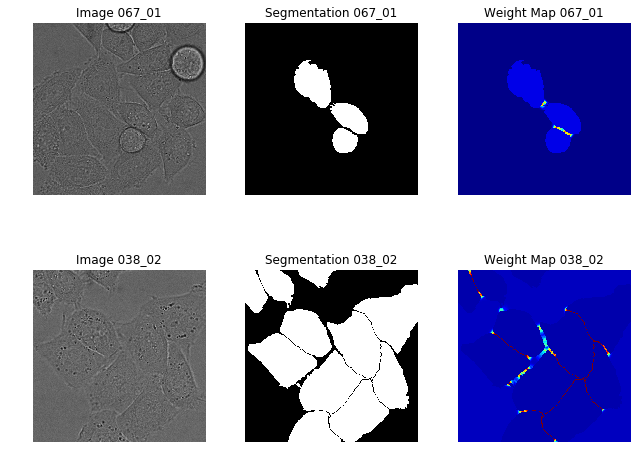

In [3]:
HeLa_dir = "../../data/u-net/DIC-C2DH-HeLa/niftynet_data/"
HeLa_images = grab_demo_images(HeLa_dir, ['067_01', '038_02'], {'img': 'img_', 'seg': 'bin_seg_', 'weight':'weight_'})

plot_slides(HeLa_images, figsize=(9, 7))

These results look very similar to those in Figure 3 of the original paper, so we seem to be on the right track. To do this, I eroded some of the segmentation boundaries to ensure the model learns to predict the gaps between cells, as noted in the U-Net paper. 

<a id="aug"></a>

## Data augmentation: 

In U-Net, the authors use augmentation via non-linear deformation. Searching the [documentation page](http://niftynet.readthedocs.io/en/dev/)  for deformation, I can see that there is an implementation of elastic deformation in `niftynet.layer.rand_elastic_deform module`. We will use this augmentation to create variety in our training set, which should improve generalisation to unseen data. 

**Other things:** It can be useful to track the performance on a validation set during training. To do this, NiftyNet uses a `dataset_split` csv file which allows the data to be labelled as training, validation or evaluation. Because the data for these challenges is quite small, we will use only a few images for validation monitoring.

<a id="conf"></a>
## The config file: 

To set all the options, we will use a configuration file. This will include file paths, which network to use, and other options. 

There is guidance on config files available [here](https://github.com/NifTK/NiftyNet/tree/dev/config). 

We will base our configuration files on the `config/default_segmentation.ini` file in the repository. 

Here, we go through it step-by-step: 

## Data: 

Here, I show what I've changed from the default example. 

```diff
############################ input configuration sections
-[modality1]
+[cells]   # you can name this whatever you want
-csv_file=  # we will find the images by searching
-path_to_search = ./example_volumes/monomodal_parcellation
+path_to_search = ./data/u-net/PhC-C2DH-U373/niftynet_data
-filename_contains = T1
+filename_contains = img_
-filename_not_contains =
-spatial_window_size = (20, 42, 42)
+spatial_window_size = (572, 572, 1)  
interp_order = 3
-pixdim=(1.0, 1.0, 1.0)
-axcodes=(A, R, S)
+loader = skimage

[label]
-path_to_search = ./example_volumes/monomodal_parcellation
+./data/u-net/PhC-C2DH-U373/niftynet_data
-filename_contains = Label
+filename_contains = bin_seg_
filename_not_contains =
-spatial_window_size = (20, 42, 42)
+spatial_window_size = (388, 388, 1)
interp_order = 0
-pixdim=(1.0, 1.0, 1.0)
-axcodes=(A, R, S)
+loader = skimage

+[xent_weights]  # pre-computed cross-entropy weights 
+path_to_search = ./data/u-net/PhC-C2DH-U373/niftynet_data
+filename_contains = weight_
+filename_not_contains =
+spatial_window_size = (388, 388, 1)
+interp_order = 3
+loader = skimage

```

I've taken out the bits that look relevant, and also added something to load in the weights for the loss function. 

The differences: we need to use a loader other than nibabel (I chose skimage, although there are other options). This is to avoid converting the images to nifti before training. We load in binary segmentations for training, although you could also explicitly tell NiftyNet to match all non-zero labels to 1. This way is slightly easier for us to visualise as users, and do appropriate checks.  



## System Parameters 
```diff
[SYSTEM]
cuda_devices = ""
-num_threads = 2
+num_threads = 10
num_gpus = 1
-model_dir = ./models/model_monomodal_toy
```
For the `SYSTEM` parameters, I increased the number of threads (my machine is pretty hefty) and deleted the model directory (we will set this later). I have removed `model_dir`, as we will set it via the command line. 


## Network 

```diff
[NETWORK]
-name = toynet
+name = unet_2d 
-activation_function = prelu
+activation_function = relu 
- batch_size = 1
+ batch_size = 4 
- decay = 0.1
- reg_type = L2

# volume level preprocessing
-volume_padding_size = 21
+volume_padding_size = (92, 92, 0)
+volume_padding_mode = symmetric # this will pad the images with reflection, as per the paper

-# histogram normalisation
-histogram_ref_file = ./example_volumes/monomodal_parcellation/standardisation_models.txt
-norm_type = percentile
-cutoff = (0.01, 0.99)
normalisation = False
-whitening = False
+whitening = True
-normalise_foreground_only=True
+normalise_foreground_only=False
-foreground_type = otsu_plus
-multimod_foreground_type = and

queue_length = 20
```

I have told the network to use U-Net, and also changed the default normalisation options. I do not want 'foreground' normalisation, as our images take up the whole field of view of the image file. I need the volume padding, because U-Net wouldn't produce segmentation results for voxels near the border otherwise. 


## Training

```diff
[TRAINING]
-sample_per_volume = 32
+sample_per_volume = 2
-rotation_angle = (-10.0, 10.0)
-scaling_percentage = (-10.0, 10.0)
-random_flipping_axes= 1
+random_flipping_axes= 0, 1
-lr = 0.01
+lr = 0.0003
-loss_type = Dice
+loss_type = CrossEntropy
starting_iter = 0
-save_every_n = 100
+save_every_n = 500
-max_iter = 10
+max_iter = 10000
max_checkpoints = 20

+do_elastic_deformation = True
+deformation_sigma = 50
+num_ctrl_points = 6
+proportion_to_deform=0.9

+validation_every_n = 10
+validation_max_iter = 1

```

The major things I have changed here relate are the loss function and the augmentation. I use the (weighted) cross-entropy, as per the original paper. I also add some instructions for the elastic deformation. Finally, I add an instruction for validation to occur every ten iterations. For the specific deformation parameters, I have determined these by independent experimentation (not shown here). 

<a id="datavis"></a>

## Visualising the effects of pre-processing: 

Here, we are giong to visualise the effects of data augmentation (specifically the random elastic deformation) to get some idea of what we should set the parameters to. I'm building this visualisation from the tools in `demos/module_examples`, where it shows how to visualise the effects of the pre-processing. 

Step 1: build a minimal pipeline to see the effects of the augmentation. I will need normalisation (and I remember I used the `whitening` flag. I will need some padding (again, I chose the `volume_padding_mode` to be `symmetric` for this problem). Finally, I will add a `RandomElasticDeformationLayer`. I will visualise the results of this augmentation and choose a value that seems appropriate. Were the problem one we wanted to heavily optimise, it may be worth cross-validating over parameter choices. Here, however, we just want something that looks reasonable. 

In [169]:
import sys
niftynet_path = '../../'
sys.path.append(niftynet_path)


from niftynet.io.image_reader import ImageReader
from niftynet.contrib.dataset_sampler.sampler_uniform_v2 import UniformSampler
from niftynet.layer.pad import PadLayer
from niftynet.layer.rand_elastic_deform import RandomElasticDeformationLayer
from niftynet.layer.mean_variance_normalisation import MeanVarNormalisationLayer
from niftynet.layer.rand_flip import RandomFlipLayer


def create_image_reader(num_controlpoints, std_deformation_sigma):
    # creating an image reader.
    data_param = \
        {'cell': {'path_to_search': '../../data/u-net/PhC-C2DH-U373/niftynet_data', # PhC-C2DH-U373, DIC-C2DH-HeLa
                'filename_contains': 'img_',
                'loader': 'skimage'},
         'label': {'path_to_search': '../../data/u-net/PhC-C2DH-U373/niftynet_data', # PhC-C2DH-U373, DIC-C2DH-HeLa
                'filename_contains': 'bin_seg_',
                'loader': 'skimage',
                'interp_order' : 0}
        }
    reader = ImageReader().initialise(data_param)

    reader.add_preprocessing_layers(MeanVarNormalisationLayer(image_name = 'cell'))

    reader.add_preprocessing_layers(PadLayer(
                     image_name=['cell', 'label'],
                     border=(92,92,0),
                     mode='symmetric')) 

    reader.add_preprocessing_layers(RandomElasticDeformationLayer(
                     num_controlpoints=num_controlpoints,
                     std_deformation_sigma=std_deformation_sigma,
                     proportion_to_augment=1,
                     spatial_rank=2)) 
    
#     reader.add_preprocessing_layers(RandomFlipLayer(
#                  flip_axes=(0,1))) 

    return reader



INFO:niftynet: 

Number of subjects 230, input section names: ['subject_id', 'cell', 'label']
-- using all subjects (without data partitioning).

INFO:niftynet: Image reader: loading 34 subjects from sections ('cell',) as input [cell]
INFO:niftynet: Image reader: loading 34 subjects from sections ('label',) as input [label]
INFO:niftynet: 

Number of subjects 230, input section names: ['subject_id', 'cell', 'label']
-- using all subjects (without data partitioning).

INFO:niftynet: Image reader: loading 34 subjects from sections ('cell',) as input [cell]
INFO:niftynet: Image reader: loading 34 subjects from sections ('label',) as input [label]
INFO:niftynet: 

Number of subjects 230, input section names: ['subject_id', 'cell', 'label']
-- using all subjects (without data partitioning).

INFO:niftynet: Image reader: loading 34 subjects from sections ('cell',) as input [cell]
INFO:niftynet: Image reader: loading 34 subjects from sections ('label',) as input [label]
INFO:niftynet: 

Numbe

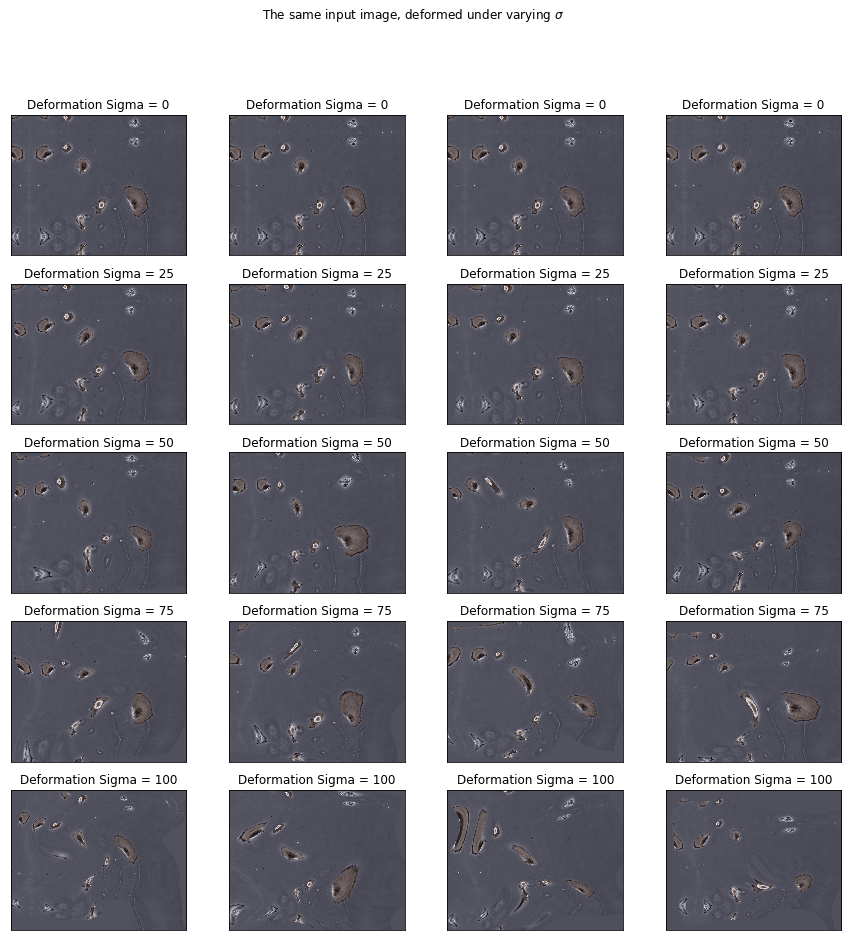

In [170]:
f, axes = plt.subplots(5,4,figsize=(15,15))
f.suptitle('The same input image, deformed under varying $\sigma$')

for i, axe in enumerate(axes): 
    std_sigma = 25 * i
    reader = create_image_reader(6, std_sigma)
    for ax in axe: 
        _, image_data, _ = reader(1)
        ax.imshow(image_data['cell'].squeeze(), cmap='gray')
        ax.imshow(image_data['label'].squeeze(), cmap='jet', alpha=0.1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Deformation Sigma = %i' % std_sigma)
# f.set_tight_layout('tight')


To my eyes, 50 seems about the right number: some significant deformation (images look quite different) but without much in the way of distorting the cells beyond recognisability (like in $\sigma=100$).

## Inference

```diff
[INFERENCE]
-border = (0, 0, 1)
+border = (92, 92, 0)  # please note the zero-entry in the last dimension. 
-#inference_iter = 10
+inference_iter = -1 # use last available checkpoint for inference
-save_seg_dir = ./output/toy
+save_seg_dir = ./output
output_interp_order = 0
-spatial_window_size = (0, 0, 3)
+spatial_window_size = (572, 572, 1)
```

These changes all relate to the specific requirements of 2-d U-Net.


## Finishing the config file: 

We just have to tell the network the final details. 

```diff
[SEGMENTATION]
-image = modality1
+image = cells
label = label
+weight = xent_weights
output_prob = False
-num_classes = 160
+num_classes = 2
-label_normalisation = True
+label_normalisation = False

```

`label normalisation` is unnecessary, as we already binarised the labels ourselves. Otherwise, this is a case of telling the `segmentation` application how to use the data we've specified. 

<a id="exp"></a>

# The Experiments: 


Although there are many experiments you could do, I will do a simple one: 

Which augmentation methods lead to the best performance of the segmentation tool? 

To do this, I will vary the augmentation: I will either do: 

1. no augmentation (baseline) 
2. random flips 
3. elastic deformation 
4. flips + deformation 

To do this, I will create similar `.ini` files, with difference augmentation options and `model_dir` parameter. 

You can see the approach I took to do this in the file `/demos/unet/generate_run_commands.py`. Here, I programmatically generate different test conditions. I do this by using the fact that command line options override any options specified in the `.ini` files, so I can use one common `.ini` file as long as I specify a different `model_dir`. 

## The train/test split: 

Each experiment has only 2 sets of data, with some number of labeled images for each. I will therefore do a 2-fold cross-validation: using only one set of the data, I will try to predict the results for the other. 

I thus have one further option to give to the `.ini` file: in `[SYSTEM]`, I will set the `dataset_split_file` option.


## Commands for the command line: 

By running the file, I show here an example of the command line commands I will use. 

```
python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation True --random_flipping_axes '0,1' --dataset_split_file ../../demos/unet/u373_d_split_1.csv --model_dir ./models/U373_0

python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation True --random_flipping_axes '0,1' --dataset_split_file ../../demos/unet/u373_d_split_2.csv --model_dir ./models/U373_1

python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation True --random_flipping_axes -1 --dataset_split_file ../../demos/unet/u373_d_split_1.csv --model_dir ./models/U373_2

python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation True --random_flipping_axes -1 --dataset_split_file ../../demos/unet/u373_d_split_2.csv --model_dir ./models/U373_3

python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation False --random_flipping_axes '0,1' --dataset_split_file ../../demos/unet/u373_d_split_1.csv --model_dir ./models/U373_4

python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation False --random_flipping_axes '0,1' --dataset_split_file ../../demos/unet/u373_d_split_2.csv --model_dir ./models/U373_5

python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation False --random_flipping_axes -1 --dataset_split_file ../../demos/unet/u373_d_split_1.csv --model_dir ./models/U373_6

python net_segment.py train -c ./demos/unet/U373.ini --do_elastic_deformation False --random_flipping_axes -1 --dataset_split_file ../../demos/unet/u373_d_split_2.csv --model_dir ./models/U373_7
```


<a id="tb"></a>

## Monitoring during training

NiftyNet, by default, tracks training progress. To see this, use a command like: `tensorboard --logdir models`. 

I used this to choose a minimal point for the `Validation` set to do the inference. 

The commands for inference are similar to aboce, except `train` is replaced by `inference` and I set the `--inference_iter` parameter depending on the training curves.

<a id="results"></a>

## Looking at Results: 

In this section, we will look at the results from these various experiments. I have made a few functions here, to show the model outputs (a useful sense-check) and collate the results in a tabular form. 

There are several helper functions I've written here for this specific task.


In [138]:
def dice_score(gt, img): 
    "Calculate the dice score for evaluation purposes"
    gt, img = [x > 0 for x in (gt, img)]
    num = 2 * np.sum(gt & img)
    den = gt.sum() + img.sum() 
    return num / den
    
def results(ground_truths, estimate_dirs):
    "Collates the dice scores from various experiments"
    results = {e: [] for e in estimate_dirs}
    results['ids'] = [] 
    for f in ground_truths:
        r = re.search('.*bin_seg_(.*_\d+)', f)
        if r: 
            gt = imread(f)
            subj_id = r.group(1)
            results['ids'].append(subj_id)
            for exp_name in estimate_dirs: 
                est_path = os.path.join(estimate_dirs[exp_name], subj_id + '_niftynet_out.nii.gz')
                est = nib.load(est_path).get_data().squeeze() 
                results[exp_name].append(dice_score(gt, est))
                
    df = pd.DataFrame(results)
    return df
    
def results_long(df, csv_name):
    "Labels the results as from train or validation datasets"
    d_split = pd.read_csv(csv_name)
    d_split.columns = ('ids', 'fold')
    merged_df = pd.merge(df, d_split)
    df_long = pd.melt(merged_df, id_vars=['ids', 'fold'])
    return df_long

def show_model_outputs(df, est_dirs, subj_ids, axes):
    "Plots the results for visualisation"
    for est_dir in est_dirs.values():
        for i, sid in enumerate(subj_ids):
            a = imread([f for f in ground_truths if sid in f][0])
            estimates = [os.path.join(est_dir, f) for f in os.listdir(est_dir) if f.endswith('.gz')]
            b = nib.load(est_dir + '/' + sid +'_niftynet_out.nii.gz').get_data().squeeze()

            axes[i].imshow(np.hstack([a, b, a-b]), cmap='gray')
            axes[i].set_axis_off()
            
            train_or_val = df[df['ids']==sid]['fold'].values[0]
            axes[i].set_title('{} Fold: Ground truth, Estimate and Difference. Dice Score = {:.2f}'.format(
                train_or_val, dice_score(a, b)))

def add_experiment_info_to_datasets(df, est_dirs):
    "adds the experimental information from the training settings"
    experiment_numbers, flipping, dataset_splits, deforming = [], [], [], []

    for est_dir_key in est_dirs:
        # getting the dataset_split file from the settings_train txt file: 
        train_settings = ' '.join([l.strip() for l in open(est_dirs[est_dir_key]+'../settings_train.txt', 'r')])

        experiment_numbers.append(est_dir_key)

        r = re.search('dataset_split_file:\s.*(\d).csv', train_settings)
        dataset_splits.append(r.group(1))

        r = re.search('flipping_axes:\s\((.*?)\)', train_settings)
        flip = 'False' if '-1' in r.group(1) else 'True'
        flipping.append(flip)

        r = re.search('elastic_deformation:\s(\w+)', train_settings)
        deforming.append(r.group(1))

    data_dict = {'variable': experiment_numbers, 
                 'flip': flipping,
                 'deform': deforming,
                 'train_split': dataset_splits,
                 'augmentations': ['_'.join(['flip', x[0], 'def', y[0]]) for x, y in zip(flipping, deforming)]
                }

    conditions_df = pd.DataFrame(data_dict)
    combined_df = pd.merge(df, conditions_df)

    return combined_df
            
            
def get_and_plot_results(est_dirs, subj_ids):
    df = None 
    for est_dir_key in est_dirs:

        # getting the dataset_split file from the settings_train txt file: 
        train_settings = [l.strip() for l in open(est_dirs[est_dir_key]+'../settings_train.txt', 'r')]
        dataset_split_file = [x.split(':')[1].strip() for x in train_settings if 'dataset_split' in x][0]

        new_df = results(ground_truths, {est_dir_key: est_dirs[est_dir_key]})
        new_df_long = results_long(new_df, dataset_split_file)

        f, axes = plt.subplots(2, 1, figsize=(9,5))
        f.suptitle("Experiment %s" %est_dir_key)
        show_model_outputs(new_df_long, {est_dir_key: est_dirs[est_dir_key]}, subj_ids, axes)

        if df is None:
            df = new_df_long
        else:
            df = pd.concat([df, new_df_long])
            
    combined_df = add_experiment_info_to_datasets(df, est_dirs)
    return combined_df

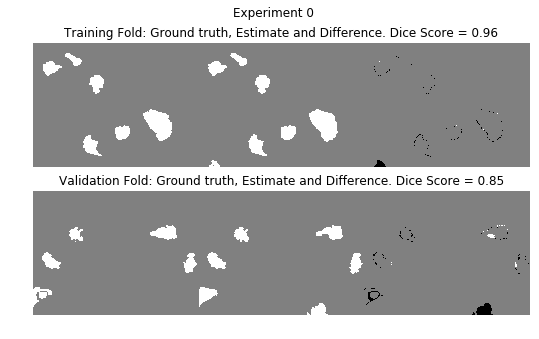

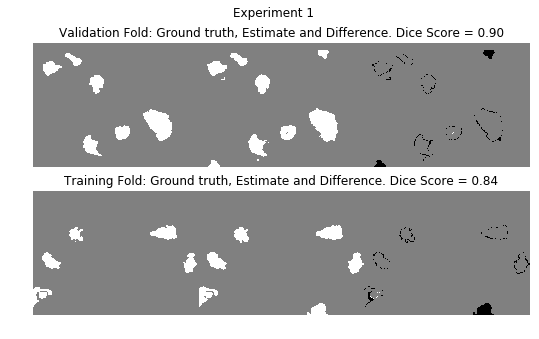

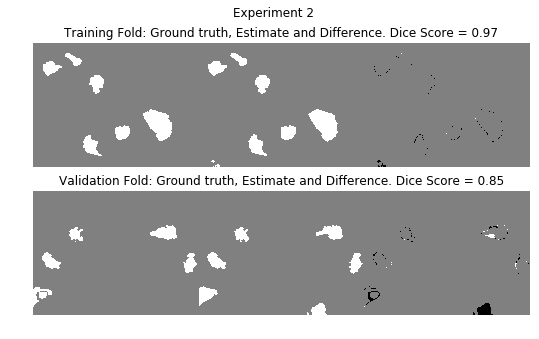

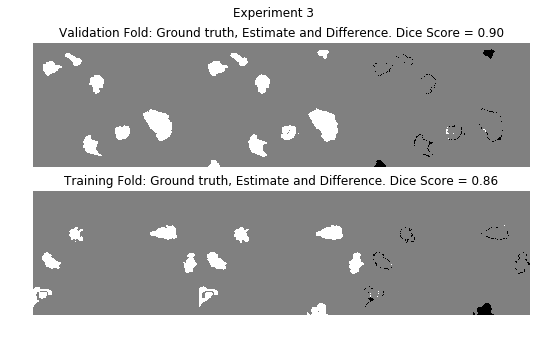

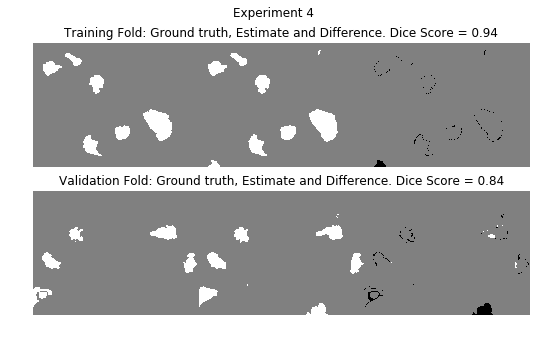

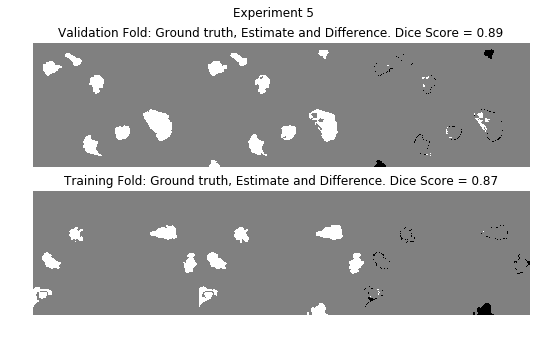

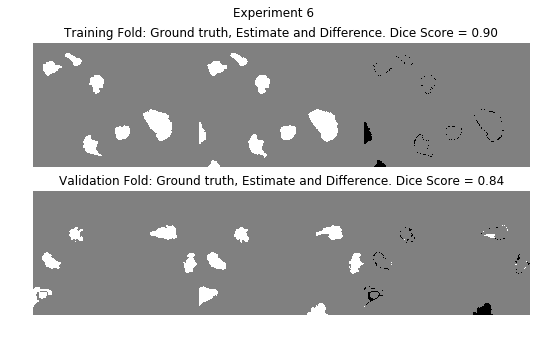

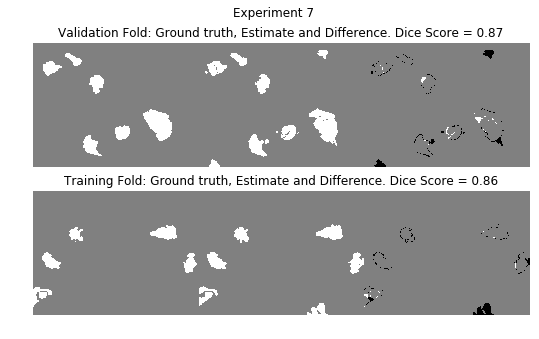

In [139]:
data_dir = "../../data/u-net/PhC-C2DH-U373/niftynet_data/"

ground_truths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('bin_seg')]
est_dirs = {x: "../../models/U373_" + str(x) + "/output/" for x in range(8)}
u373_ids = ('001_01', '059_02')

df_u373 = get_and_plot_results(est_dirs, u373_ids)
    


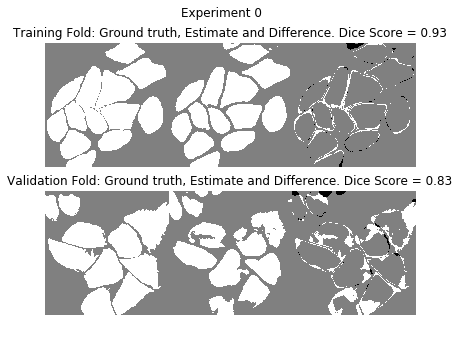

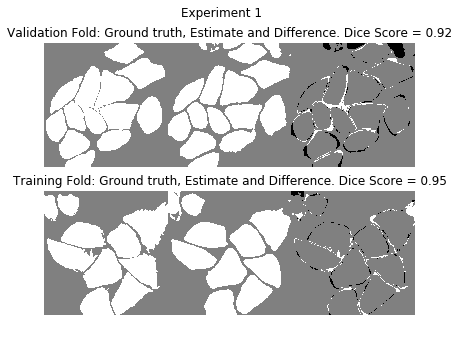

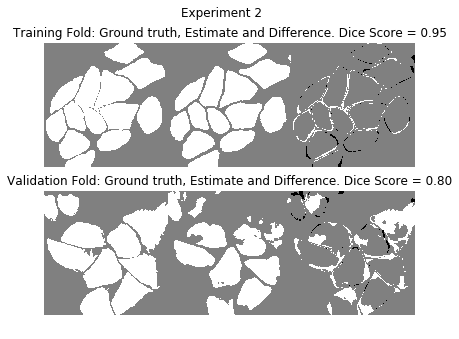

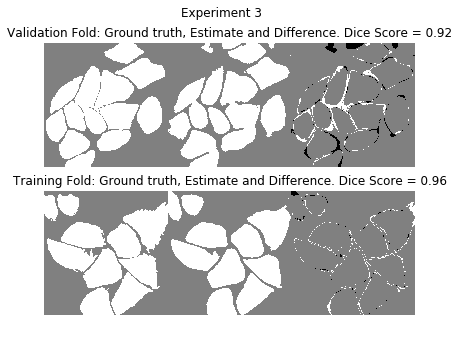

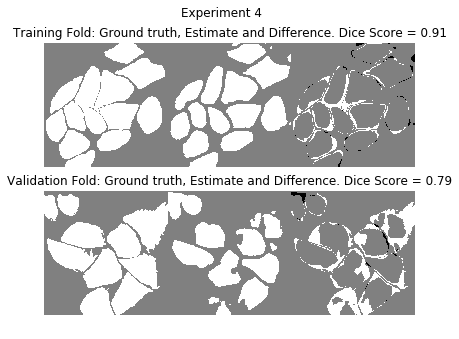

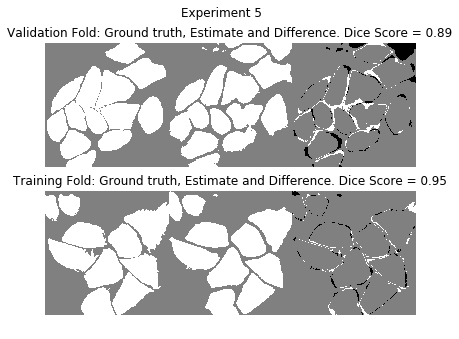

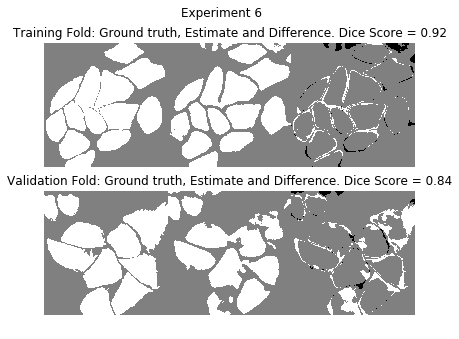

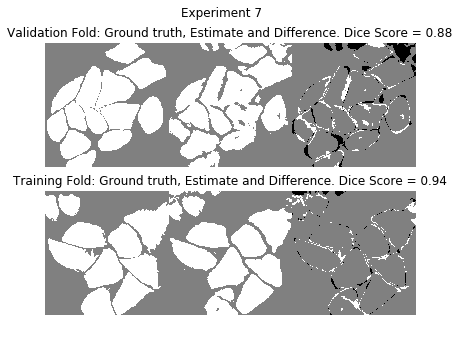

In [132]:
data_dir = "../../data/u-net/DIC-C2DH-HeLa/niftynet_data/"

ground_truths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('bin_seg')]
est_dirs = {x: "../../models/HeLa_" + str(x) + "/output/" for x in range(8)}

hela_ids = ('039_01', '034_02')

df_hela = get_and_plot_results(est_dirs, hela_ids)


Text(0.5,1,'Dice score for HeLa data')

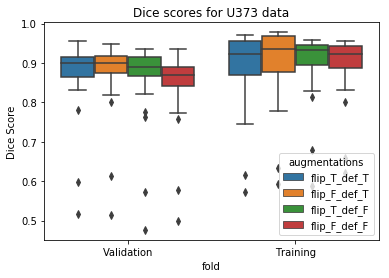

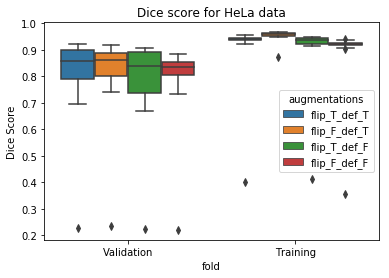

In [161]:
import seaborn as sns
f, ax = plt.subplots()
sns.boxplot('fold', 'value', data=df_u373, hue='augmentations', ax=ax)
ax.set_ylabel('Dice Score')
ax.set_title('Dice scores for U373 data')

f, ax = plt.subplots()
sns.boxplot('fold', 'value', data=df_hela, hue='augmentations', ax=ax)
ax.set_ylabel('Dice Score')
ax.set_title('Dice score for HeLa data')



In [160]:
print('Mean scores for validation on U373: Paper gets 0.9203')

for meth in np.unique(df_u373['augmentations']):
    print(meth, df_u373[(df_u373['fold']=='Validation') & (df_u373['augmentations']==meth)]['value'].mean())

print('Mean scores for validation on HeLa: Paper gets 0.7756')
for meth in np.unique(df_hela['augmentations']):
    print(meth, df_hela[(df_hela['fold']=='Validation') & (df_hela['augmentations']==meth)]['value'].mean())


Mean scores for validation on U373: Paper gets 0.9203
flip_F_def_F 0.8473459917119964
flip_F_def_T 0.876098366581922
flip_T_def_F 0.8656362831535208
flip_T_def_T 0.876622324210172
Mean scores for validation on HeLa: Paper gets 0.7756
flip_F_def_F 0.7927651375180577
flip_F_def_T 0.8153034423789014
flip_T_def_F 0.7886978570433607
flip_T_def_T 0.8140490489143175


<a id="analysis"></a>

### Analysing the results: 

We have performed a two-fold cross-validation for each of the datasets presented. The segmentations look similar to the ground truth. One difference is that the estimations tend to highlight regions that are not in the ground truth. This may be because the labels for the Cell Tracking Challenge are not complete (this was part of the challenge). 

Comparing our results to the results in the U-Net paper, we should remember that we've used only half of the training data for validating the results. Thus, our scores should be lower than on the challenge. 

However, we did not go through the final steps of the challenge: giving the 'blobs' different labels and making sure that touching blobs were resolved as two separate cells. This means that our score for the HeLa results is going to be too high. 

Looking above at the results, we are in the ballpark of the published results. 

In terms of augmentations, while there is not that much data, using deformations does seem to improve on the baseline of 'no augmentations'. It is not clear if flipping helps if you're also using deformations. 


### Possible extensions: 

Were I to continue this investigation, I may look into different labelling of the training images. The HeLa results seem to be under-segmented, staying away from the highly-weighted gaps between cells. It may be possible to use a different labelling to avoid this (for instance, labelling the borders with a separate class label).

### Wrapping up: 

We have gone through how to do an experimental pipeline in NiftyNet, based on the experiments in the U-Net paper. While we have produced a lot of data and done a lot of work, the key components in the experiments were determined in the `config` files. By using command-line arguments to NiftyNet, we geenerated several experimental conditions. Finally, we generated and analysed the resulting data. 

### References


[1] Ronneberger, O., Fischer, P., & Brox, T. (2015, October). U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.